#### Explore [CORINE Land Cover](https://land.copernicus.eu/en/map-viewer?dataset=0407d497d3c44bcd93ce8fd5bf78596a) data 2018 for Belgium - data collected using *by country* option

1. Explore CORINE landuse data
2. Explore landuse/landcoverage around solar and wind infrastructures (data from `BE_power.ipynb`)

Dependencies:

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely import wkt
from shapely.geometry import MultiPoint
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from collections import Counter
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
from matplotlib.colors import ListedColormap
# utils functions 
from utils import get_landuse_share, find_landuses_within_buffer, find_area_covered_by_landuse_within_buffer
# utils plots
from utils import parse_color, map_by_label, freq_landuse_types, bubble_map

Data paths:

In [2]:
# path to CORINE geodatabase (.gdb)
gdb_path = '../data/EU_data/CORINE_Belgium/Results/U2018_CLC2018_V2020_20u1.gdb'
# path codes legend
path_legend = '../data/EU_data/CORINE_Belgium/Results/U2018_CLC2018_V2020_20u1_doc/Info/Legend/Vector/clc_legend.xls'

# OSM data (preprocessed)
wind_data_path = 'output_data/BE/BE_wind_df.csv' # OSM wind turbines data
solar_data_path = 'output_data/BE/BE_solar_df.csv' # OSM solar farms data

# EPSG for conversions
epsg_meter = 3035 # EPSG:3035
epsg_latlon = 4326 # EPSG:4326

_________

In [3]:
# get layer names
layers = fiona.listlayers(gdb_path)

# put each layer into geodataframe
for layer_name in layers:
    layer_gdf = gpd.read_file(gdb_path, driver='OpenFileGDB', layer=layer_name)
    # print(layer_gdf.head())  


/home/luisa/Documents/OSM_StateOfTheMap_Conference_Nairobi2024/OSMRenewables/.venv/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
/home/luisa/Documents/OSM_StateOfTheMap_Conference_Nairobi2024/OSMRenewables/.venv/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [4]:
layer_gdf.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

In [5]:
layer_gdf = layer_gdf.to_crs(epsg_latlon)

<Axes: >

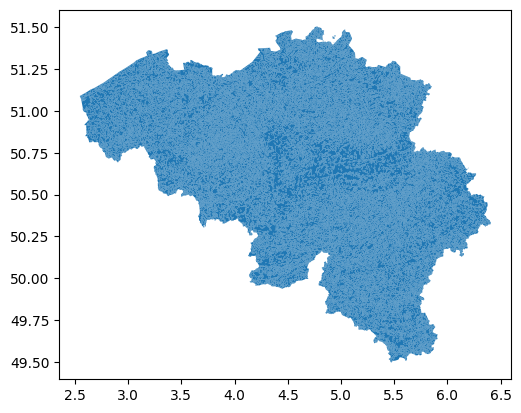

In [6]:
layer_gdf.plot()

In [7]:
legend_df = pd.read_excel(path_legend)
legend_df

GRID_CODE  CLC_CODE                         LABEL1  \
0           1       111            Artificial surfaces   
1           2       112            Artificial surfaces   
2           3       121            Artificial surfaces   
3           4       122            Artificial surfaces   
4           5       123            Artificial surfaces   
5           6       124            Artificial surfaces   
6           7       131            Artificial surfaces   
7           8       132            Artificial surfaces   
8           9       133            Artificial surfaces   
9          10       141            Artificial surfaces   
10         11       142            Artificial surfaces   
11         12       211             Agricultural areas   
12         13       212             Agricultural areas   
13         14       213             Agricultural areas   
14         15       221             Agricultural areas   
15         16       222             Agricultural areas   
16         17       223             Agricultural areas   
17         18       231             Agricultural areas   
18         19       241             Agricultural areas   
19         20       242             Agricultural areas   
20         21       243             Agricultural areas   
21         22       244             Agricultural areas   
22         23       311  Forest and semi natural areas   
23         24       312  Forest and semi natural areas   
24         25       313  Forest and semi natural areas   
25         26       321  Forest and semi natural areas   
26         27       322  Forest and semi natural areas   
27         28       323  Forest and semi natural areas   
28         29       324  Forest and semi natural areas   
29         30       331  Forest and semi natural areas   
30         31       332  Forest and semi natural areas   
31         32       333  Forest and semi natural areas   
32         33       334  Forest and semi natural areas   
33         34       335  Forest and semi natural areas   
34         35       411                       Wetlands   
35         36       412                       Wetlands   
36         37       421                       Wetlands   
37         38       422                       Wetlands   
38         39       423                       Wetlands   
39         40       511                   Water bodies   
40         41       512                   Water bodies   
41         42       521                   Water bodies   
42         43       522                   Water bodies   
43         44       523                   Water bodies   
44         48       999                         NODATA   
45         49       990                   UNCLASSIFIED   
46         50       995                   UNCLASSIFIED   
47        255       990                   UNCLASSIFIED   

                                             LABEL2  \
0                                      Urban fabric   
1                                      Urban fabric   
2        Industrial, commercial and transport units   
3        Industrial, commercial and transport units   
4        Industrial, commercial and transport units   
5        Industrial, commercial and transport units   
6                 Mine, dump and construction sites   
7                 Mine, dump and construction sites   
8                 Mine, dump and construction sites   
9      Artificial, non-agricultural vegetated areas   
10     Artificial, non-agricultural vegetated areas   
11                                      Arable land   
12                                      Arable land   
13                                      Arable land   
14                                  Permanent crops   
15                                  Permanent crops   
16                                  Permanent crops   
17                                         Pastures   
18                 Heterogeneous agricultural areas   
19                 Heterogeneous agricultural areas   
20    

In [8]:
layer_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24126 entries, 0 to 24125
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Code_18       24126 non-null  object  
 1   Remark        0 non-null      object  
 2   Area_Ha       24126 non-null  float64 
 3   ID            24126 non-null  object  
 4   Shape_Length  24126 non-null  float64 
 5   Shape_Area    24126 non-null  float64 
 6   geometry      24126 non-null  geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 1.3+ MB


In [9]:
layer_gdf['Code_18'] = layer_gdf['Code_18'].astype('int')
legend_df['GRID_CODE'] = legend_df['GRID_CODE'].astype('int')

In [10]:
# merge gdf with legend
gdf = layer_gdf.merge(legend_df, left_on='Code_18', right_on='CLC_CODE', how='left')

In [11]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
gdf[(gdf.LABEL1=='UNCLASSIFIED') | (gdf.LABEL1 == 'NODATA')]

Empty GeoDataFrame
Columns: [Code_18, Remark, Area_Ha, ID, Shape_Length, Shape_Area, geometry, GRID_CODE, CLC_CODE, LABEL1, LABEL2, LABEL3, RGB]
Index: []

In [13]:
gdf.LABEL3.nunique()

31

In [14]:
gdf[['RGB', 'LABEL3']]

RGB                        LABEL3
0      230-000-077       Continuous urban fabric
1      230-000-077       Continuous urban fabric
2      230-000-077       Continuous urban fabric
3      230-000-077       Continuous urban fabric
4      230-000-077       Continuous urban fabric
...            ...                           ...
24121  128-255-000           Broad-leaved forest
24122  000-204-242                 Water courses
24123  230-242-255                 Sea and ocean
24124  255-230-077  Complex cultivation patterns
24125  255-230-077  Complex cultivation patterns

[24126 rows x 2 columns]

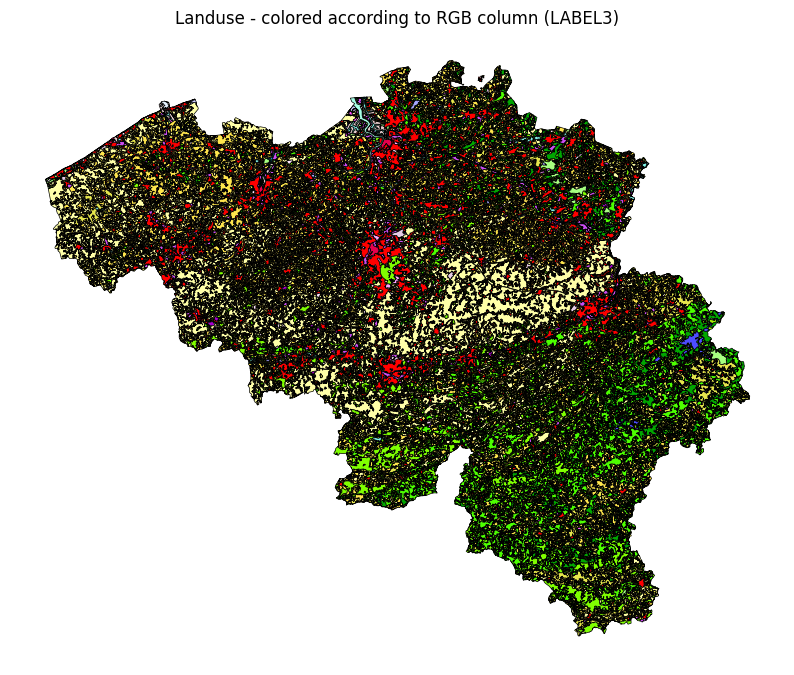

In [15]:
# convert the RGB column to RGB tuples
colors = gdf['RGB'].apply(parse_color)

# plot landuse on map according to CORINE color-scheme
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5, color=colors, legend=True)
plt.title('Landuse - colored according to RGB column (LABEL3)')
plt.axis('off')
plt.show()


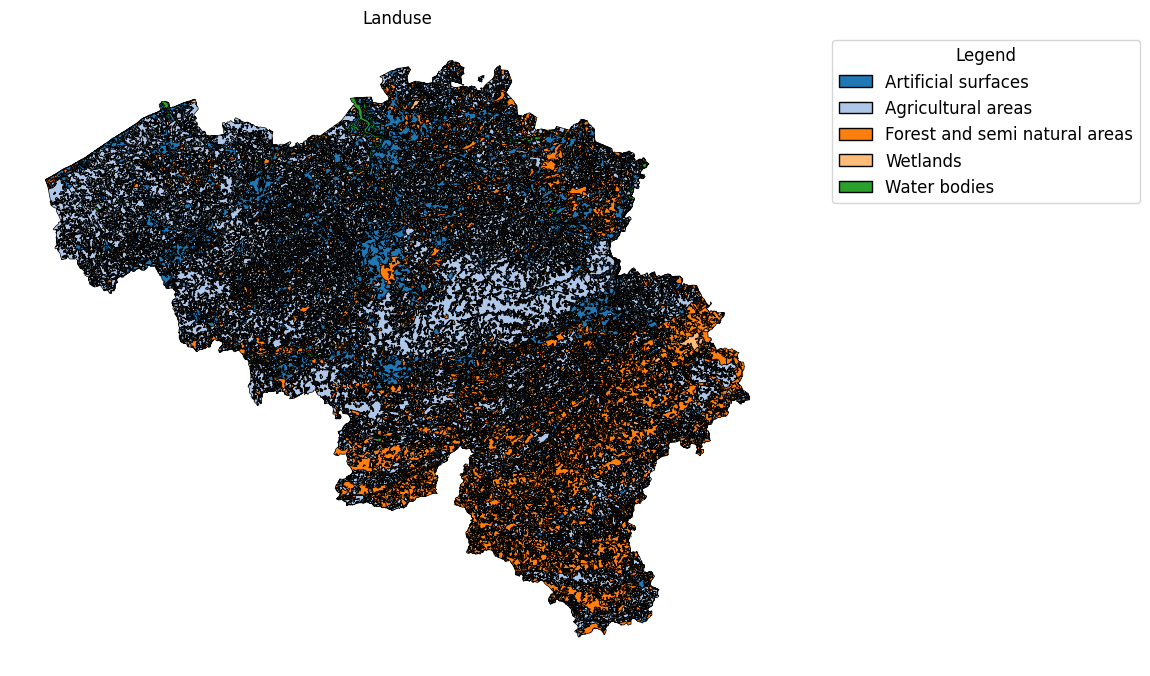

In [16]:
# plot landuse on map according to LABEL1 (more generic)
map_by_label(gdf, lab='LABEL1')

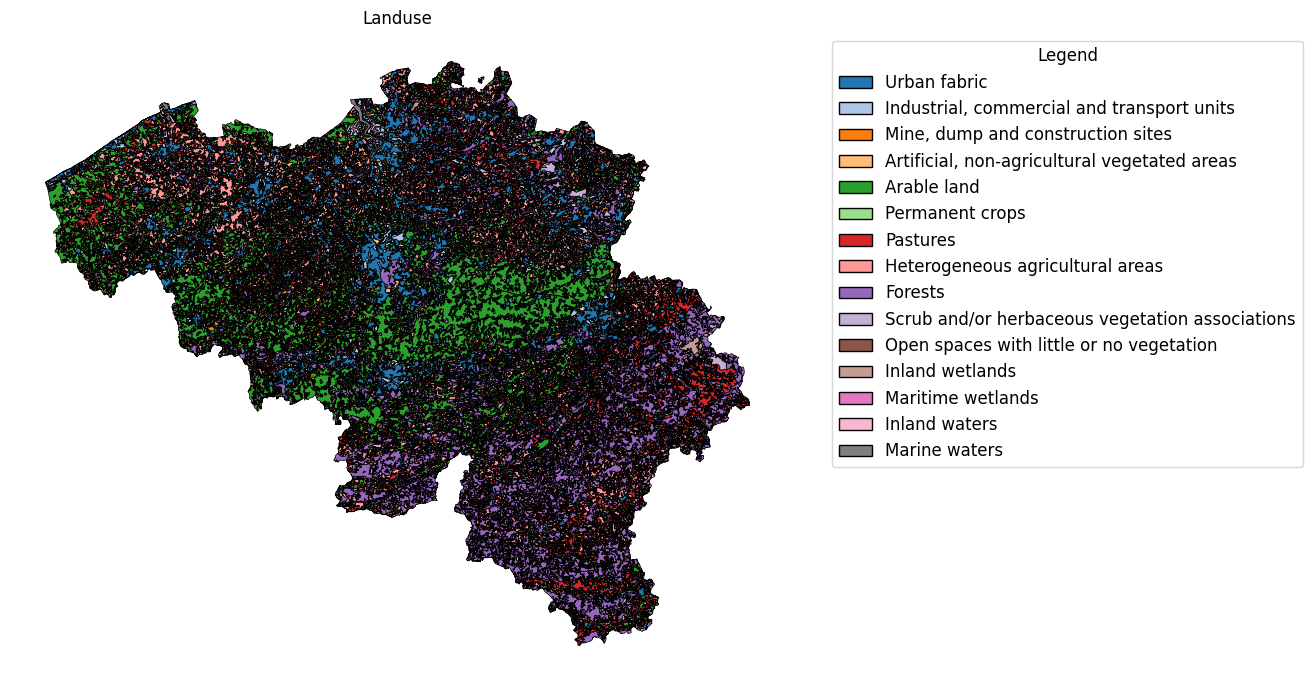

In [17]:
# plot landuse on map according to LABEL2 (intermediate specifications)
map_by_label(gdf, 'LABEL2')

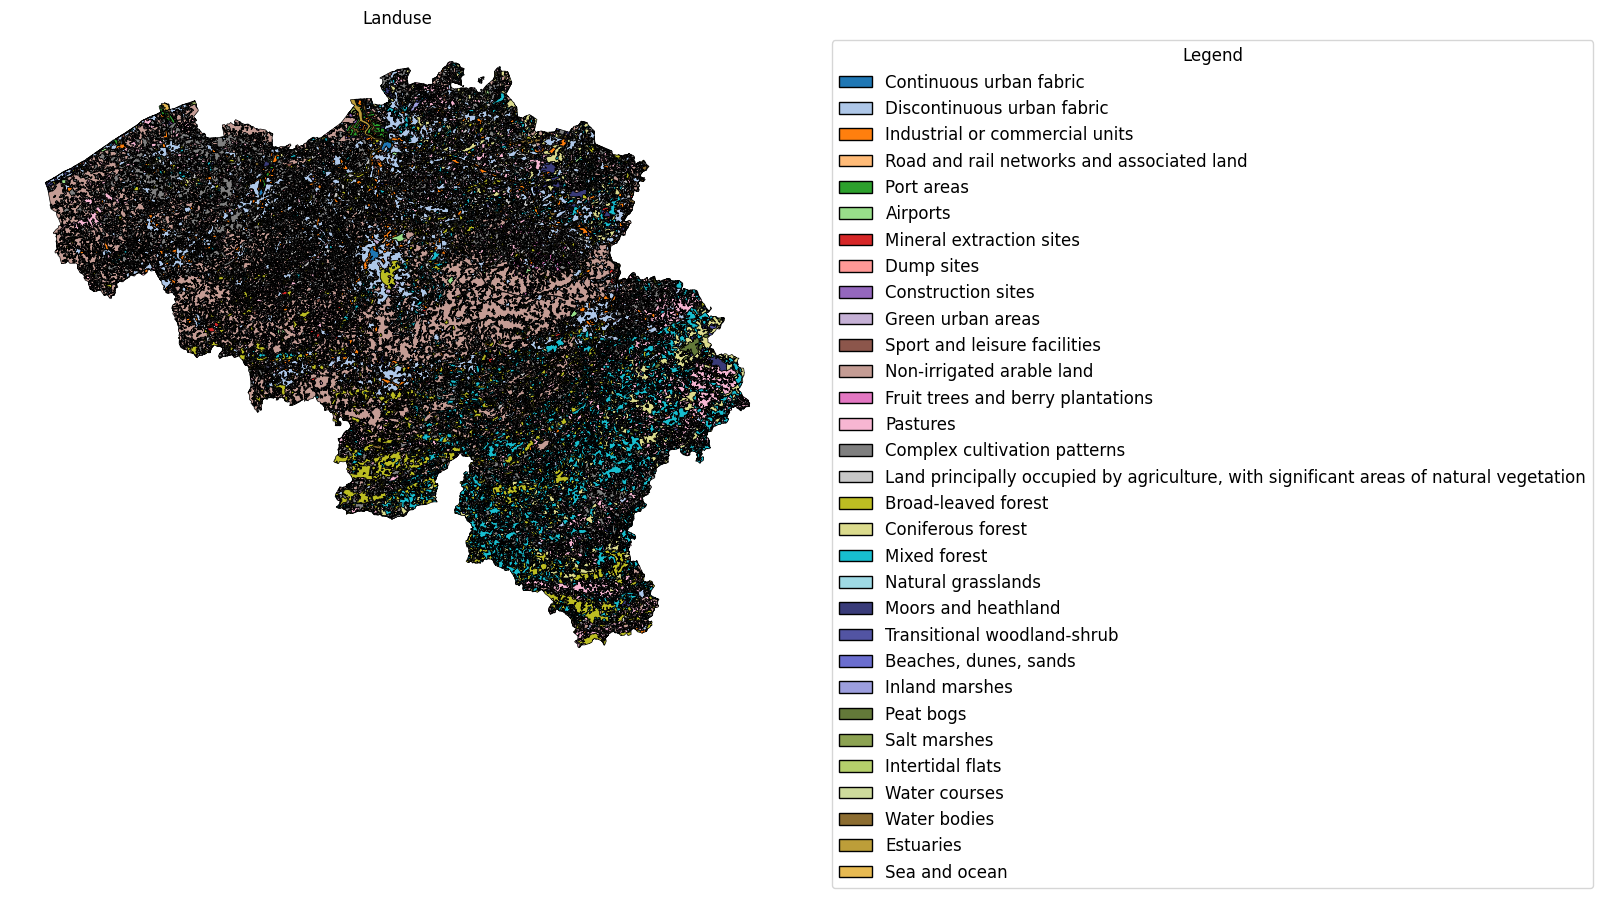

In [18]:
# plot landuse on map according to LABEL3 (detailed)
map_by_label(gdf, 'LABEL3')

Compute percentage of total land covered by each landuse category:

In [16]:
# landuse data in metric and mercator coordinate systems
landuse_gdf = gdf.to_crs(epsg=epsg_latlon)
landuse_gdf_metric = gdf.to_crs(epsg=epsg_meter) # gdf was already in metric system

In [17]:
# extensions of each landuse in Ireland (% of total country area)
# remove sea from percentage computation
gdf_metric_no_sea = landuse_gdf_metric[landuse_gdf_metric.LABEL2 != 'Marine waters'] 

# landuse share according to LABEL1
get_landuse_share(gdf=gdf_metric_no_sea, grp_by_landuse_col='LABEL1')

LABEL1
Agricultural areas               57.099793
Forest and semi natural areas    21.129981
Artificial surfaces              20.931704
Water bodies                      0.537195
Wetlands                          0.301327
Name: geometry, dtype: float64

In [18]:
# landuse share according to LABEL2
get_landuse_share(gdf=gdf_metric_no_sea, grp_by_landuse_col='LABEL2')

LABEL2
Heterogeneous agricultural areas                   23.505685
Arable land                                        21.792654
Forests                                            19.916893
Urban fabric                                       17.130173
Pastures                                           11.504202
Industrial, commercial and transport units          2.656201
Scrub and/or herbaceous vegetation associations     1.179636
Artificial, non-agricultural vegetated areas        0.829621
Inland waters                                       0.537195
Mine, dump and construction sites                   0.315709
Permanent crops                                     0.297253
Inland wetlands                                     0.267384
Maritime wetlands                                   0.033943
Open spaces with little or no vegetation            0.033453
Name: geometry, dtype: float64

In [19]:
# landuse share according to LABEL3
get_landuse_share(gdf=gdf_metric_no_sea, grp_by_landuse_col='LABEL3')

LABEL3
Non-irrigated arable land                                                                 21.792654
Complex cultivation patterns                                                              17.377938
Discontinuous urban fabric                                                                16.963265
Pastures                                                                                  11.504202
Mixed forest                                                                               8.763210
Broad-leaved forest                                                                        6.792595
Land principally occupied by agriculture, with significant areas of natural vegetation     6.127747
Coniferous forest                                                                          4.361088
Industrial or commercial units                                                             1.889548
Sport and leisure facilities                                                               0.

In [20]:
# total surface in squared-km
gdf_metric_no_sea.geometry.area.sum() / 1000000 

30617.51235217803

____________

#### Explore landuse/landcoverage around solar and wind infrastructures

#### WIND

In [21]:
wind_df = pd.read_csv(wind_data_path, index_col=0)
wind_df['geometry'] = wind_df['geometry'].apply(wkt.loads)

wind_gdf = gpd.GeoDataFrame(wind_df, crs=epsg_latlon, geometry='geometry')

In [22]:
wind_gdf

id        lat       lon  power_tag  power_method power_source  \
0       n33518330  51.139601  2.761360  generator           NaN         wind   
1      n258894561  50.877840  5.652012  generator           NaN         wind   
2      n258894597  50.880019  5.655342  generator           NaN         wind   
3      n258895042  50.882037  5.658758  generator           NaN         wind   
4      n293029421  50.538995  4.517857  generator  wind_turbine         wind   
...           ...        ...       ...        ...           ...          ...   
1096  n2363447976        NaN       NaN  generator  wind_turbine         wind   
1097  n2455660238        NaN       NaN  generator  wind_turbine         wind   
1098  n2456106378        NaN       NaN  generator  wind_turbine         wind   
1099  n2456114704        NaN       NaN  generator  wind_turbine         wind   
1100  n2456114734        NaN       NaN  generator  wind_turbine         wind   

           power_type                  geometry  relation_id relation_type  \
0     horizontal_axis   POINT (2.76136 51.1396)          NaN           NaN   
1                 NaN  POINT (5.65201 50.87784)          NaN           NaN   
2                 NaN  POINT (5.65534 50.88002)          NaN           NaN   
3                 NaN  POINT (5.65876 50.88204)          NaN           NaN   
4     horizontal_axis    POINT (4.51786 50.539)          NaN           NaN   
...               ...                       ...          ...           ...   
1096  horizontal_axis  POINT (4.28768 51.18182)          NaN           NaN   
1097              NaN  POINT (4.13734 51.02638)          NaN           NaN   
1098  horizontal_axis  POINT (4.13864 51.02374)          NaN           NaN   
1099              NaN  POINT (4.15187 51.02439)          NaN           NaN   
1100  horizontal_axis  POINT (4.14405 51.02185)          NaN           NaN   

     relation_info area_id  cluster_id  
0              NaN     NaN         0.0  
1              NaN     NaN         1.0  
2              NaN     NaN         1.0  
3              NaN     NaN         1.0  
4              NaN     NaN         2.0  
...            ...     ...         ...  
1096           NaN     NaN        48.0  
1097           NaN     NaN       250.0  
1098           NaN     NaN       250.0  
1099           NaN     NaN       250.0  
1100           NaN     NaN       250.0  

[1101 rows x 13 columns]

In [23]:
# use spatial join to get landuse on turbines locations
wind_farms_with_landuse = gpd.sjoin(wind_gdf, landuse_gdf, how='left', predicate='within')
wind_farms_with_landuse.drop(columns=['index_right'], inplace=True)
wind_farms_with_landuse

id        lat       lon  power_tag  power_method power_source  \
0       n33518330  51.139601  2.761360  generator           NaN         wind   
1      n258894561  50.877840  5.652012  generator           NaN         wind   
2      n258894597  50.880019  5.655342  generator           NaN         wind   
3      n258895042  50.882037  5.658758  generator           NaN         wind   
4      n293029421  50.538995  4.517857  generator  wind_turbine         wind   
...           ...        ...       ...        ...           ...          ...   
1096  n2363447976        NaN       NaN  generator  wind_turbine         wind   
1097  n2455660238        NaN       NaN  generator  wind_turbine         wind   
1098  n2456106378        NaN       NaN  generator  wind_turbine         wind   
1099  n2456114704        NaN       NaN  generator  wind_turbine         wind   
1100  n2456114734        NaN       NaN  generator  wind_turbine         wind   

           power_type                  geometry  relation_id relation_type  \
0     horizontal_axis   POINT (2.76136 51.1396)          NaN           NaN   
1                 NaN  POINT (5.65201 50.87784)          NaN           NaN   
2                 NaN  POINT (5.65534 50.88002)          NaN           NaN   
3                 NaN  POINT (5.65876 50.88204)          NaN           NaN   
4     horizontal_axis    POINT (4.51786 50.539)          NaN           NaN   
...               ...                       ...          ...           ...   
1096  horizontal_axis  POINT (4.28768 51.18182)          NaN           NaN   
1097              NaN  POINT (4.13734 51.02638)          NaN           NaN   
1098  horizontal_axis  POINT (4.13864 51.02374)          NaN           NaN   
1099              NaN  POINT (4.15187 51.02439)          NaN           NaN   
1100  horizontal_axis  POINT (4.14405 51.02185)          NaN           NaN   

      ...       Area_Ha         ID  Shape_Length    Shape_Area GRID_CODE  \
0     ...     53.822165  EU_557236  3.796476e+03  5.382216e+05      12.0   
1     ...    355.401885  EU_555579  1.032010e+04  1.252381e+06      12.0   
2     ...    355.401885  EU_555579  1.032010e+04  1.252381e+06      12.0   
3     ...    355.401885  EU_555579  1.032010e+04  1.252381e+06      12.0   
4     ...  99921.861195  EU_555481  2.501852e+06  9.992186e+08      12.0   
...   ...           ...        ...           ...           ...       ...   
1096  ...    448.414490  EU_557129  2.834531e+04  4.484145e+06      12.0   
1097  ...    178.157057  EU_546709  7.474950e+03  1.781571e+06       3.0   
1098  ...    178.157057  EU_546709  7.474950e+03  1.781571e+06       3.0   
1099  ...    178.157057  EU_546709  7.474950e+03  1.781571e+06       3.0   
1100  ...    178.157057  EU_546709  7.474950e+03  1.781571e+06       3.0   

      CLC_CODE               LABEL1  \
0        211.0   Agricultural areas   
1        211.0   Agricultural areas   
2        211.0   Agricultural areas   
3        211.0   Agricultural areas   
4        211.0   Agricultural areas   
...        ...                  ...   
1096     211.0   Agricultural areas   
1097     121.0  Artificial surfaces   
1098     121.0  Artificial surfaces   
1099     121.0  Artificial surfaces   
1100     121.0  Artificial surfaces   

                                          LABEL2  \
0                                    Arable land   
1                                    Arable land   
2                                    Arable land   
3                                    Arable land   
4                                    Arable land   
...                                          ...   
1096                                 Arable land   
1097  Industrial, commercial and transport units   
1098  Industrial, commercial and transport units   
1099  Industrial, commercial and transport units   
1100  Industrial, commercial and transport units   

                              LABEL3          RGB  
0          Non-irrigated arable land  255-255-168  
1     

In [27]:
# wind_farms_with_landuse.info()

In [24]:
print('Number of wind turbines without associated landuse (missing CORINE data): {} over {}'.format(len(wind_farms_with_landuse[wind_farms_with_landuse.LABEL2.isna()]), len(wind_farms_with_landuse)))

Number of wind turbines without associated landuse (missing CORINE data): 2 over 1101


In [25]:
wind_farms_with_landuse[wind_farms_with_landuse.LABEL2.isna()]

id        lat       lon  power_tag  power_method power_source  \
415  n3905339449  50.786509  3.107828  generator  wind_turbine         wind   
980  n9584909120  51.469067  4.712019  generator  wind_turbine         wind   

          power_type                  geometry  relation_id relation_type  \
415              NaN  POINT (3.10783 50.78651)          NaN           NaN   
980  horizontal_axis  POINT (4.71202 51.46907)          NaN           NaN   

     ... Area_Ha   ID  Shape_Length  Shape_Area GRID_CODE  CLC_CODE LABEL1  \
415  ...     NaN  NaN           NaN         NaN       NaN       NaN    NaN   
980  ...     NaN  NaN           NaN         NaN       NaN       NaN    NaN   

     LABEL2  LABEL3  RGB  
415     NaN     NaN  NaN  
980     NaN     NaN  NaN  

[2 rows x 25 columns]

Missing data: two turbines with missing landuse  
They are located slightly outside/close to the border of the country, thus not included in CORINE country data. Those turbines can be discarded as we are only interested in Belgium data.  
It is important to account whether they belonged to a cluster (farm) completely outside the border or extending over multiple countries.

In [26]:
# CHECK TURBINES WHERE NO CORINE DATA --> they are all slightly outside the border of the country, thus not included in CORINE country data
# those turbines can be discarded as we are only interested in this country
m = folium.Map(location=[50.5, 4], zoom_start=7)

# to geojson
missing_wind_json = wind_farms_with_landuse[wind_farms_with_landuse.LABEL2.isna()].to_json()

folium.GeoJson(missing_wind_json, color='red',
               tooltip=folium.GeoJsonTooltip(fields=['id'], 
                                              aliases=['ID'])).add_to(m)

folium.LayerControl().add_to(m)

m

In [27]:
# clusters/farms of the turbines
clusters_on_borders = wind_farms_with_landuse[wind_farms_with_landuse.LABEL2.isna()].cluster_id.unique()
clusters_on_borders

array([110.,  24.])

In [28]:
## remove turbines with unknown landuse (turbines outside or on country borders)
# discard
wind_gdf = wind_gdf[~wind_gdf.id.isin(wind_farms_with_landuse[wind_farms_with_landuse.LABEL2.isna()].id.to_list())].reset_index(drop=True)
wind_farms_with_landuse = wind_farms_with_landuse[~wind_farms_with_landuse.LABEL2.isna()].reset_index(drop=True)


# if once removed those turbines, their cluster (farm) is inside the country borders and contains multiple turbines, keep it
# otherwise discard cluster (standalone turbines)
for cluster in clusters_on_borders:
    if len(wind_gdf[wind_gdf.cluster_id == cluster]) <= 1:
        print(f'Discard cluster {cluster} - one single node inside')
        wind_gdf = wind_gdf[wind_gdf.cluster_id != cluster].reset_index(drop=True)
        wind_farms_with_landuse = wind_farms_with_landuse[wind_farms_with_landuse.cluster_id != cluster].reset_index(drop=True)

Discard cluster 110.0 - one single node inside


Plot turbines location with different colors according to landuse: we focus on CORINE LABEL2 (intermediate level of landuse detail).

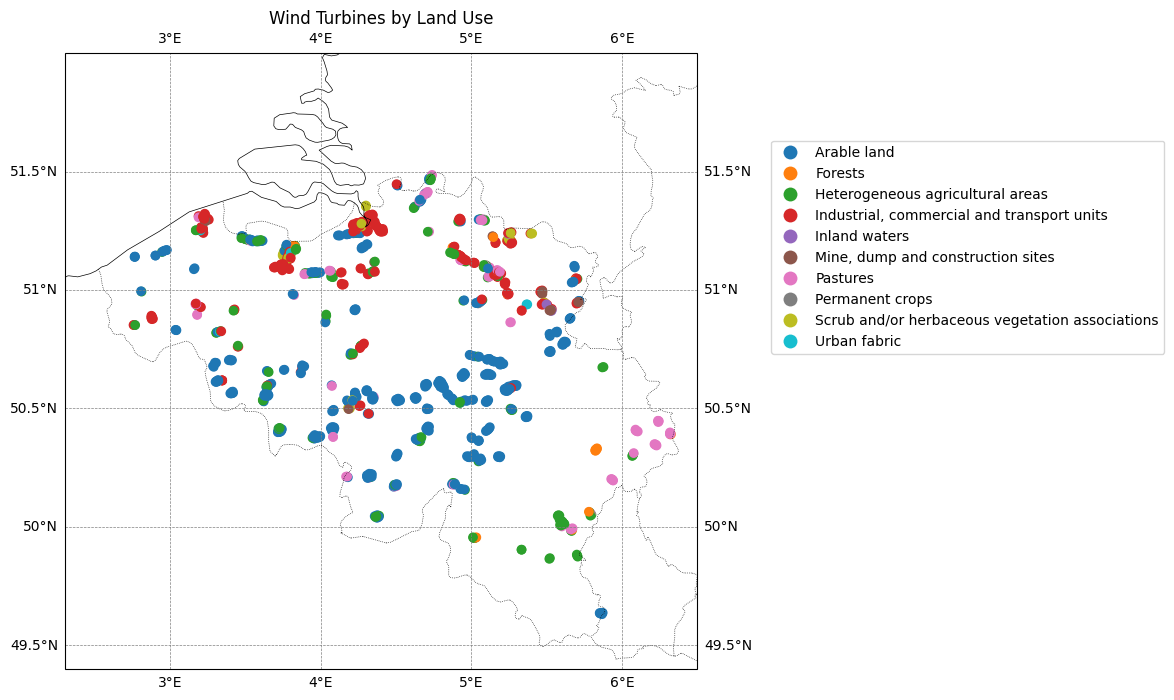

In [29]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 52])
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

wind_farms_with_landuse.plot(column='LABEL2', categorical=True, legend=True, ax=ax, legend_kwds={'loc': 'lower right', 'bbox_to_anchor': (1.75, 0.5)})

ax.set_title('Wind Turbines by Land Use')

plt.show()

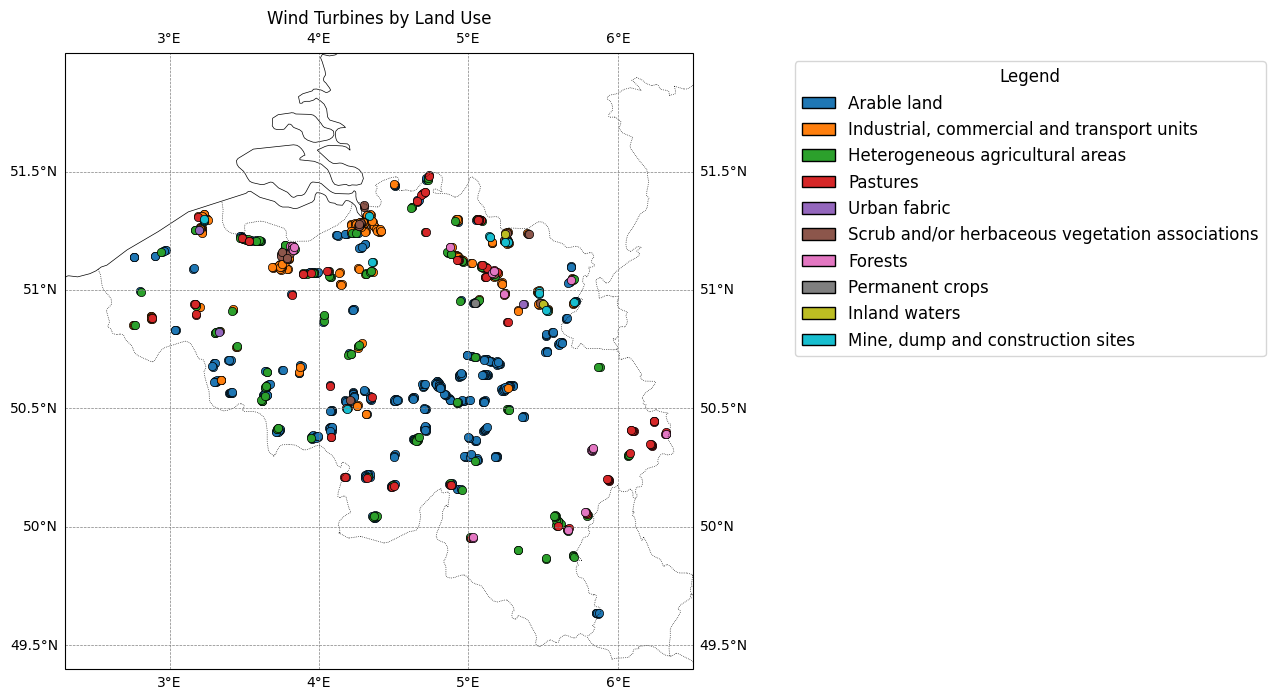

In [30]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.3, 6.5, 49.4, 52])
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

landtypes = wind_farms_with_landuse['LABEL2'].unique()
colors = sns.color_palette('tab10', n_colors=len(landtypes))
color_map = dict(zip(landtypes, colors))

for label, color in color_map.items():
    wind_farms_with_landuse[wind_farms_with_landuse['LABEL2'] == label].plot(ax=ax, facecolor=color, edgecolor='black', lw=0.5)
 
legend_elements = [Patch(facecolor=color_map[label], edgecolor='black', label=label) for label in landtypes]
ax.legend(handles=legend_elements, title='Legend', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.15, 1), loc='upper left')

ax.set_title('Wind Turbines by Land Use')

plt.show()

In [31]:
# absolute number of turbines for each landtype
wind_farms_with_landuse['LABEL2'].value_counts()

LABEL2
Arable land                                        496
Industrial, commercial and transport units         266
Heterogeneous agricultural areas                   160
Pastures                                            87
Scrub and/or herbaceous vegetation associations     33
Forests                                             25
Mine, dump and construction sites                   21
Urban fabric                                         5
Inland waters                                        4
Permanent crops                                      1
Name: count, dtype: int64

In [32]:
# percentage of turbines for each landtype
wind_farms_with_landuse['LABEL2'].value_counts() *100 / wind_farms_with_landuse['LABEL2'].value_counts().sum()

LABEL2
Arable land                                        45.173042
Industrial, commercial and transport units         24.225865
Heterogeneous agricultural areas                   14.571949
Pastures                                            7.923497
Scrub and/or herbaceous vegetation associations     3.005464
Forests                                             2.276867
Mine, dump and construction sites                   1.912568
Urban fabric                                        0.455373
Inland waters                                       0.364299
Permanent crops                                     0.091075
Name: count, dtype: float64

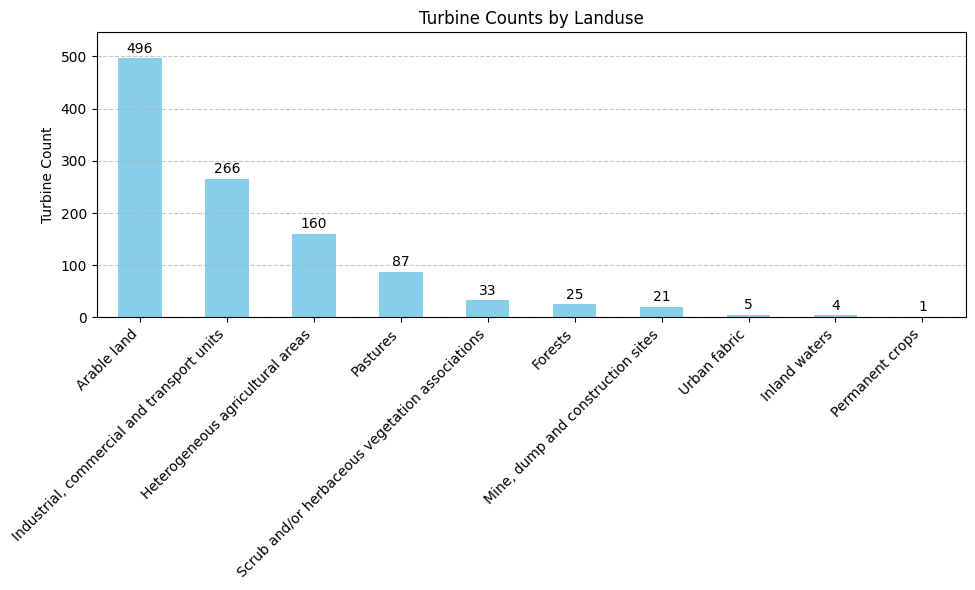

In [33]:
# turbine counts by landuse
landuse_counts = wind_farms_with_landuse['LABEL2'].value_counts()

### plot
plt.figure(figsize=(10, 6))
bars = landuse_counts.plot(kind='bar', color='skyblue')
plt.title('Turbine Counts by Landuse')
plt.xlabel('')
plt.ylabel('Turbine Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{int(bar.get_height())}', 
             ha='center', va='bottom')

plt.ylim([0, landuse_counts.max()+50])
plt.tight_layout()
plt.show()

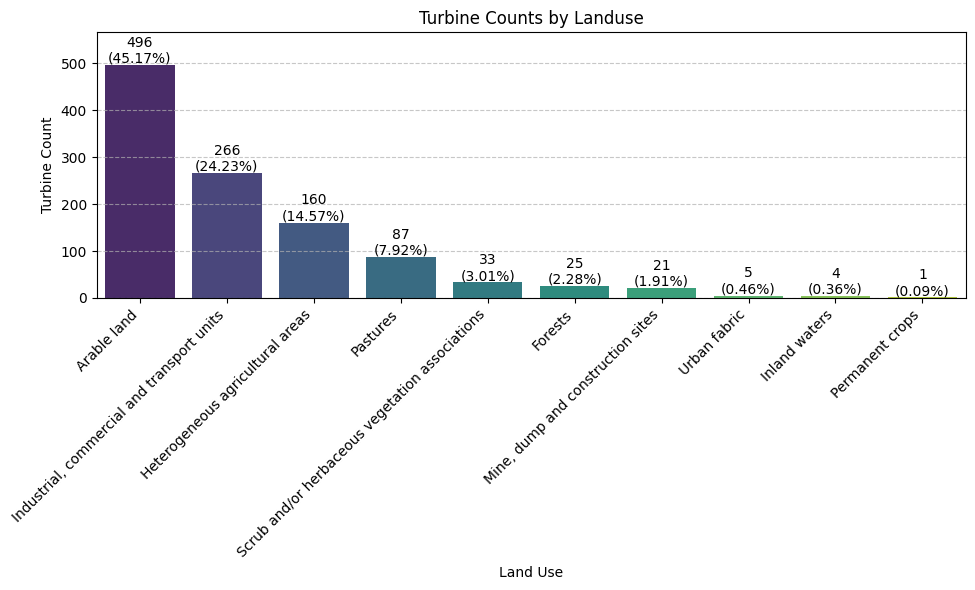

In [34]:
### barchart with percentages
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=landuse_counts.index, y=landuse_counts.values, hue= landuse_counts.index, palette='viridis')

for p in ax.patches:
    x, y = p.get_x() + p.get_width() / 2, p.get_height() + 5
    label_annotation = f'{int(p.get_height())}\n({p.get_height() / len(wind_farms_with_landuse) * 100:.2f}%)'
    ax.annotate(label_annotation, (x, y), ha='center')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Turbine Counts by Landuse')
plt.xlabel('Land Use')
plt.ylabel('Turbine Count')

plt.ylim([0, landuse_counts.values.max()+70])

plt.tight_layout()
plt.show()

Landuse within buffer:  
- turbines belonging to the same farm have the same *cluster_id*: therefore, build an area for each wind farm, encompassing only turbines belonging to the same cluster_id. 
- apply a buffer around each wind farm (area)
- detect landuses within the buffers

In [35]:
print('Total number of wind farms available: {}'.format(wind_gdf.cluster_id.nunique()))

Total number of wind farms available: 235


Build geometries of wind farms via convex hull

In [36]:
# BUILD GEOMETRIES OF WIND FARMS VIA CONVEX HULL
# group turbines into farms
farms_gdf = wind_gdf.groupby('cluster_id')

# create polygons for each wind farm
wind_farms = []
for cluster_id, group in farms_gdf:
    # build a MultiPoint object from turbine locations
    turbine_points_union = MultiPoint(group.geometry.values)
    # create a convex hull around turbine_points_union
    farm_by_convex_hull = turbine_points_union.convex_hull
    wind_farms.append((cluster_id, farm_by_convex_hull))


wind_farms_gdf = gpd.GeoDataFrame(wind_farms, columns=['cluster_id', 'geometry'], crs=epsg_latlon)
wind_farms_gdf_metric = wind_farms_gdf.to_crs(epsg_meter)

In [37]:
wind_farms_gdf_metric.geometry.type.unique() 

array(['Polygon', 'LineString'], dtype=object)

In [38]:
buffer_radius = 1000  # in meters
landuse_around_wind_farm = find_landuses_within_buffer(wind_farms_gdf_metric, landuse_gdf_metric, 'cluster_id', 'LABEL2', buffer_radius) # df format
landuse_around_wind_dict = landuse_around_wind_farm.set_index('cluster_id').to_dict()['LABEL2'] # dict format

In [39]:
for farm_id, landuse in landuse_around_wind_dict.items():
    print(f'Wind Farm n. {farm_id} presents the following landtypes within a {buffer_radius}-meters buffer:', ', '.join(landuse))

Wind Farm n. 0.0 presents the following landtypes within a 1000-meters buffer: Arable land, Artificial, non-agricultural vegetated areas, Scrub and/or herbaceous vegetation associations, Heterogeneous agricultural areas, Inland waters, Marine waters, Industrial, commercial and transport units, Pastures, Urban fabric
Wind Farm n. 1.0 presents the following landtypes within a 1000-meters buffer: Arable land, Scrub and/or herbaceous vegetation associations, Heterogeneous agricultural areas, Inland waters, Industrial, commercial and transport units, Urban fabric
Wind Farm n. 2.0 presents the following landtypes within a 1000-meters buffer: Arable land, Artificial, non-agricultural vegetated areas, Heterogeneous agricultural areas, Industrial, commercial and transport units, Urban fabric
Wind Farm n. 3.0 presents the following landtypes within a 1000-meters buffer: Arable land, Heterogeneous agricultural areas, Industrial, commercial and transport units, Pastures, Urban fabric, Forests
Wind

In [40]:
all_landuse_in_list = landuse_around_wind_farm.LABEL2.explode().tolist() # join all landuses in a single list (each landuse appearing as many times as found in the dataset)

landuse_around_cnt = Counter(all_landuse_in_list)
landuse_around_cnt

Counter({'Heterogeneous agricultural areas': 210,
         'Urban fabric': 201,
         'Arable land': 177,
         'Industrial, commercial and transport units': 144,
         'Pastures': 142,
         'Forests': 99,
         'Inland waters': 56,
         'Scrub and/or herbaceous vegetation associations': 53,
         'Artificial, non-agricultural vegetated areas': 28,
         'Mine, dump and construction sites': 27,
         'Marine waters': 12,
         'Permanent crops': 4,
         'Inland wetlands': 3,
         'Maritime wetlands': 2})

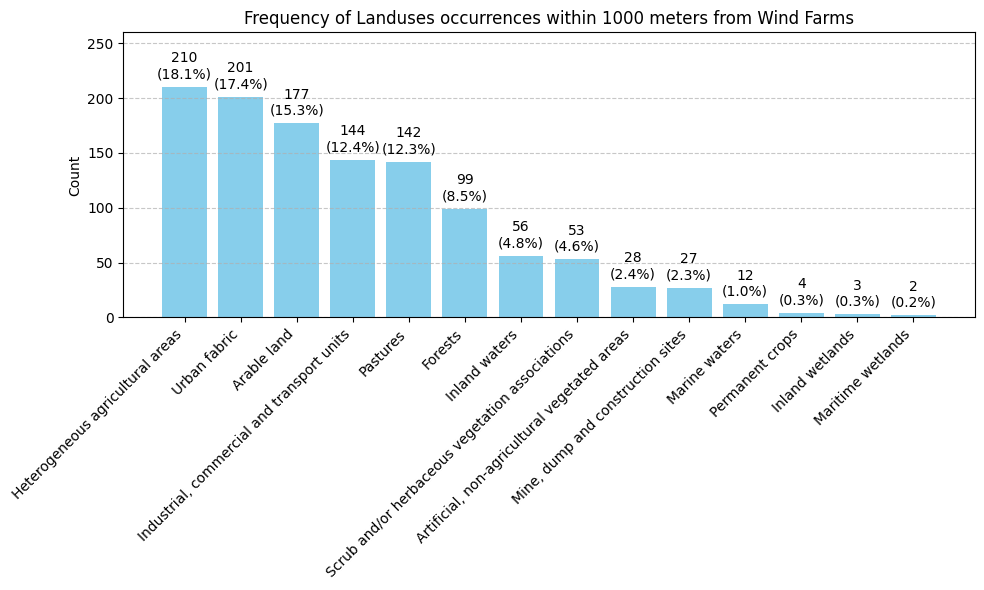

In [41]:
freq_landuse_types(landuse_around_cnt, f'Frequency of Landuses occurrences within {buffer_radius} meters from Wind Farms')

In [42]:
# compute num landuses around each farm (length of each set)
landuse_around_wind_farm['num_landuses_around'] = landuse_around_wind_farm.LABEL2.apply(lambda x: len(x))

# average number of landtypes within buffer
print('Average num of landtypes around each wind farm: {}'.format(landuse_around_wind_farm['num_landuses_around'].mean()))
# std
print('Standard deviation of num of landtypes: {}'.format(landuse_around_wind_farm['num_landuses_around'].std()))
# max
print('Maximum num of landtypes around each wind farm: {}'.format(landuse_around_wind_farm['num_landuses_around'].max()))
# min
print('Minimum num of landtypes around each wind farm: {}'.format(landuse_around_wind_farm['num_landuses_around'].min()))

Average num of landtypes around each wind farm: 4.927659574468085
Standard deviation of num of landtypes: 1.3894754171619066
Maximum num of landtypes around each wind farm: 9
Minimum num of landtypes around each wind farm: 2


In [43]:
# add geometry to landuse_around_wind_df
landuse_around_wind_gdf = pd.merge(wind_farms_gdf, landuse_around_wind_farm, how='right')
landuse_around_wind_gdf

cluster_id                                           geometry  \
0           0.0  POLYGON ((2.76136 51.1396, 2.76382 51.14124, 2...   
1           1.0  POLYGON ((5.65201 50.87784, 5.65534 50.88002, ...   
2           2.0  POLYGON ((4.50709 50.52998, 4.4987 50.53685, 4...   
3           3.0  POLYGON ((3.86705 50.64824, 3.86607 50.65012, ...   
4           4.0  POLYGON ((4.62938 50.53951, 4.6225 50.54595, 4...   
..          ...                                                ...   
230       246.0  POLYGON ((4.17043 51.23437, 4.17822 51.23533, ...   
231       247.0    LINESTRING (4.30889 51.19222, 4.30458 51.19319)   
232       248.0    LINESTRING (4.21934 51.24915, 4.21353 51.24693)   
233       249.0    LINESTRING (4.29973 51.28332, 4.29447 51.28508)   
234       250.0  POLYGON ((4.14405 51.02185, 4.13864 51.02374, ...   

                                                LABEL2  num_landuses_around  
0    {Arable land, Artificial, non-agricultural veg...                    9  
1    {Arable land, Scrub and/or herbaceous vegetati...                    6  
2    {Arable land, Artificial, non-agricultural veg...                    5  
3    {Arable land, Heterogeneous agricultural areas...                    6  
4    {Arable land, Urban fabric, Heterogeneous agri...                    3  
..                                                 ...                  ...  
230  {Arable land, Pastures, Mine, dump and constru...                    4  
231  {Arable land, Artificial, non-agricultural veg...                    5  
232  {Mine, dump and construction sites, Arable lan...                    6  
233  {Industrial, commercial and transport units, M...                    3  
234  {Industrial, commercial and transport units, U...                    4  

[235 rows x 4 columns]

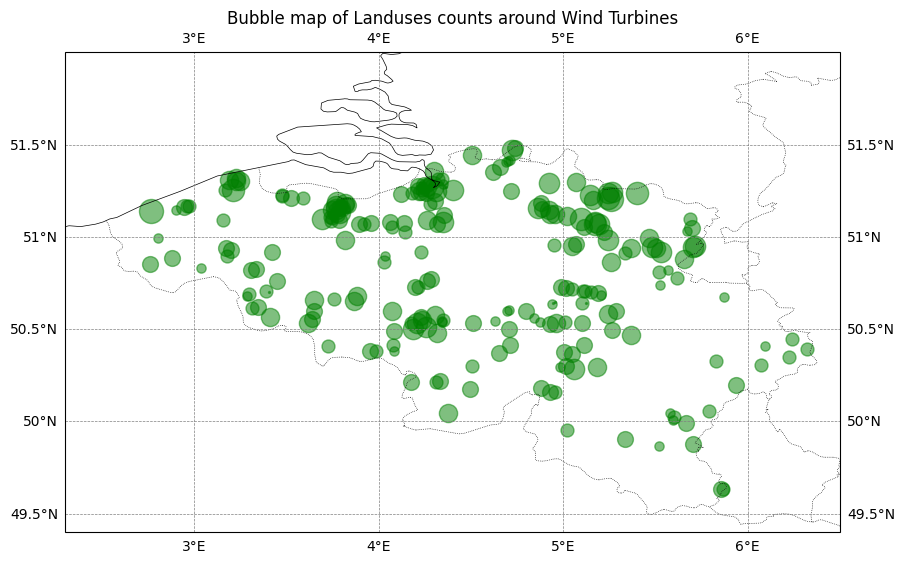

In [44]:
### BUBBLE MAP
# each bubble representing a infrastructures: the bigger the bubbles, the more landtypes are present in the infrastructures surroundings
bubble_map(gdf_mercator = landuse_around_wind_gdf, 
           bubble_sizes_column = 'num_landuses_around',
           zoom_area = [2.3, 6.5, 49.4, 52], 
           title = 'Bubble map of Landuses counts around Wind Turbines')

#### Area occupied by landuse - wind farms

Compute the percentage of land within the buffer occupied by each landuse available.

In [45]:
landuse_around_wind_meter = landuse_around_wind_gdf.to_crs(epsg_meter)
share_laduse_around_wind = find_area_covered_by_landuse_within_buffer(landuse_around_infra_gdf1_metric = landuse_around_wind_meter[['cluster_id', 'geometry']].copy(),
                                                                                landuse_gdf2_metric = landuse_gdf_metric, 
                                                                                unique_id_gdf1 = 'cluster_id', 
                                                                                label_column_gdf2 = 'LABEL2', 
                                                                                buffer_radius = buffer_radius)

In [46]:
share_laduse_around_wind

cluster_id                                      LABEL2  \
0           0.0                                 Arable land   
1           1.0                                 Arable land   
2           2.0                                 Arable land   
3           3.0                                 Arable land   
4           3.0  Industrial, commercial and transport units   
..          ...                                         ...   
423       246.0                                 Arable land   
424       247.0                                 Arable land   
425       248.0  Industrial, commercial and transport units   
426       249.0  Industrial, commercial and transport units   
427       250.0  Industrial, commercial and transport units   

     area_intersection  landuse_share_by_id  
0         5.382216e+05           100.000000  
1         9.818202e+05           100.000000  
2         7.862324e+06           100.000000  
3         1.039309e+06            44.573646  
4         1.292358e+06            55.426354  
..                 ...                  ...  
423       4.317705e+06           100.000000  
424       1.184921e+06           100.000000  
425       7.243851e+05           100.000000  
426       1.685981e+06           100.000000  
427       1.625203e+06           100.000000  

[428 rows x 4 columns]

In [47]:
# TOTAL AREA OCCUPIED BY ALL LANDTYPE CATEGORIES IN THE SURROUNDINGS OF ALL FARMS IN THE COUNTRY
grp_wind_land = share_laduse_around_wind.groupby(['LABEL2']).aggregate({'area_intersection':'sum'}).reset_index()
grp_wind_land

LABEL2  area_intersection
0                                      Arable land       3.862880e+08
1                                          Forests       3.067220e+07
2                 Heterogeneous agricultural areas       1.211074e+08
3       Industrial, commercial and transport units       1.424504e+08
4                                    Inland waters       1.327602e+07
5                Mine, dump and construction sites       7.831169e+06
6                                         Pastures       6.309102e+07
7                                  Permanent crops       1.379202e+06
8  Scrub and/or herbaceous vegetation associations       1.764643e+07
9                                     Urban fabric       3.790309e+06

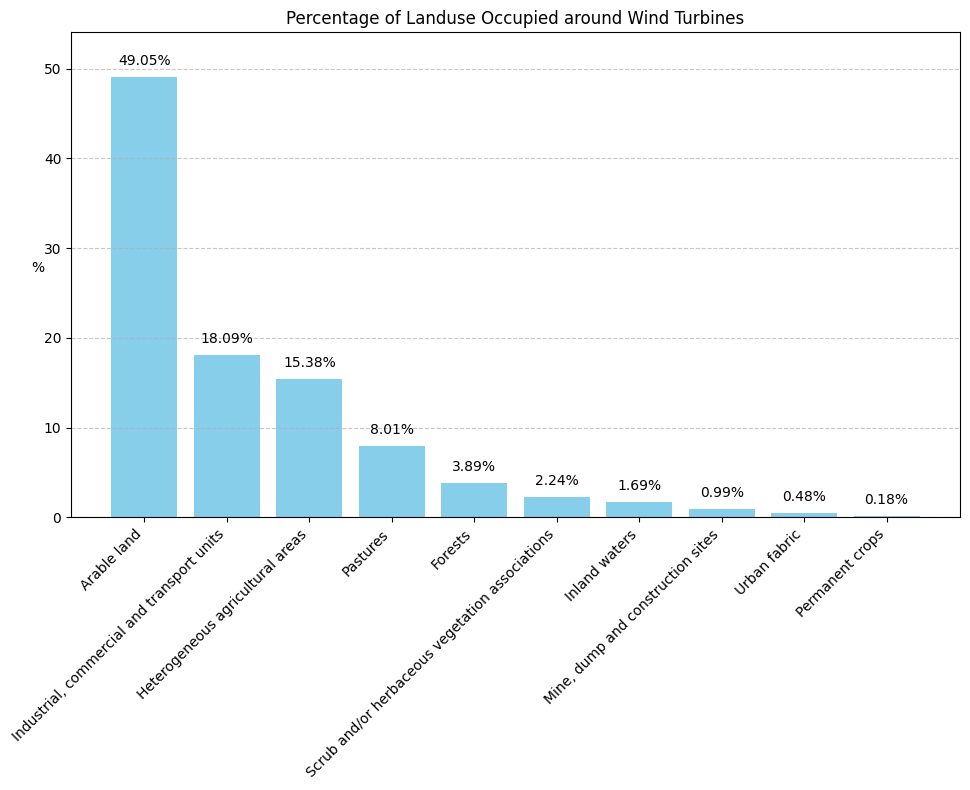

In [48]:
total_area = grp_wind_land['area_intersection'].sum()
grp_wind_land['perc_landuse'] = (grp_wind_land['area_intersection'] / total_area) * 100

# sort bars
grp_wind_land_sorted = grp_wind_land.sort_values(by='perc_landuse', ascending=False)

### plot barchart
plt.figure(figsize=(10, 8))
bars = plt.bar(grp_wind_land_sorted['LABEL2'], grp_wind_land_sorted['perc_landuse'], color='skyblue')
plt.xlabel('')
plt.ylabel('%', rotation=360)  
plt.title('Percentage of Landuse Occupied around Wind Turbines')

for bar, percentage in zip(bars, grp_wind_land_sorted['perc_landuse']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim([0, grp_wind_land_sorted['perc_landuse'].max() + 5])
plt.tight_layout()
plt.show()

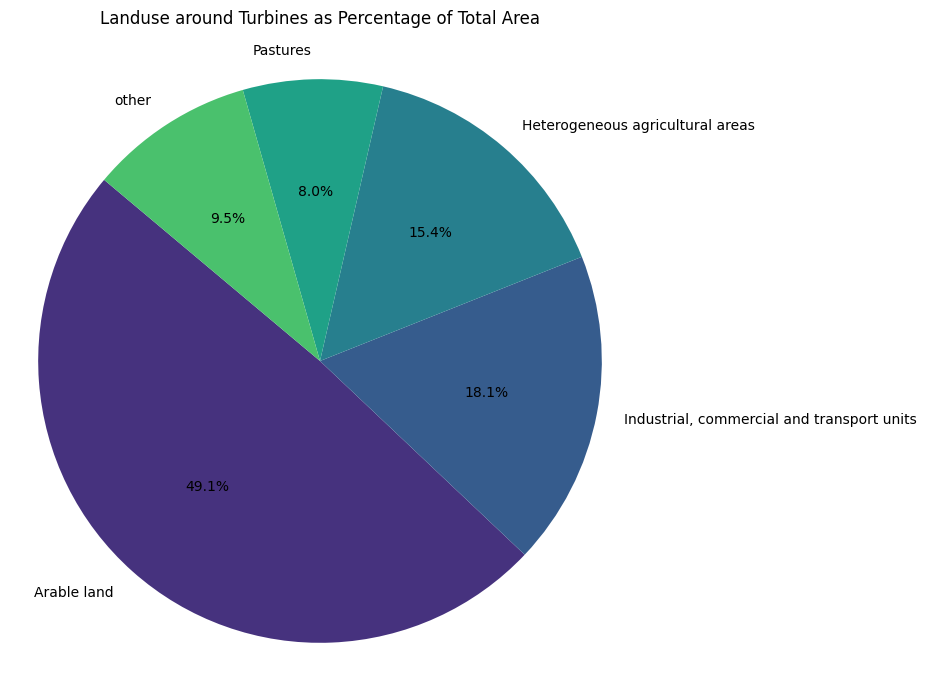

In [49]:
viz_threshold = 4.
grp_wind_land_above_threshold = grp_wind_land_sorted[grp_wind_land_sorted.perc_landuse > viz_threshold].reset_index(drop=True)
others_row = pd.DataFrame([['other', grp_wind_land_sorted[grp_wind_land_sorted.perc_landuse < viz_threshold].area_intersection.sum(), grp_wind_land_sorted[grp_wind_land_sorted.perc_landuse < viz_threshold].perc_landuse.sum()]], columns=grp_wind_land_above_threshold.columns)
reduced_wind_landuse = pd.concat([grp_wind_land_above_threshold, others_row], ignore_index=True)

### plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(reduced_wind_landuse.perc_landuse, labels=reduced_wind_landuse['LABEL2'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis') ) # rotatelabels=True
plt.title('Landuse around Turbines as Percentage of Total Area\n')
plt.axis('equal')  
plt.show()

#### SOLAR

Analyse the landtypes within a certain buffer.

In [60]:
solar_df = pd.read_csv(solar_data_path, index_col=0)
solar_df['geometry'] = solar_df['geometry'].apply(wkt.loads)

solar_gdf = gpd.GeoDataFrame(solar_df, crs=epsg_latlon, geometry='geometry')
solar_gdf_metric = solar_gdf.to_crs(epsg_meter)

In [61]:
landuse_around_solar_df = find_landuses_within_buffer(solar_gdf_metric, landuse_gdf_metric, 'id', 'LABEL2', buffer_radius) # df format
landuse_around_solar_dict = landuse_around_solar_df.set_index('id').to_dict()['LABEL2'] # dict format

In [62]:
# different types of agricultural land
gdf[gdf.LABEL1 == 'Agricultural areas'].LABEL2.unique()

array(['Arable land', 'Permanent crops', 'Pastures',
       'Heterogeneous agricultural areas'], dtype=object)

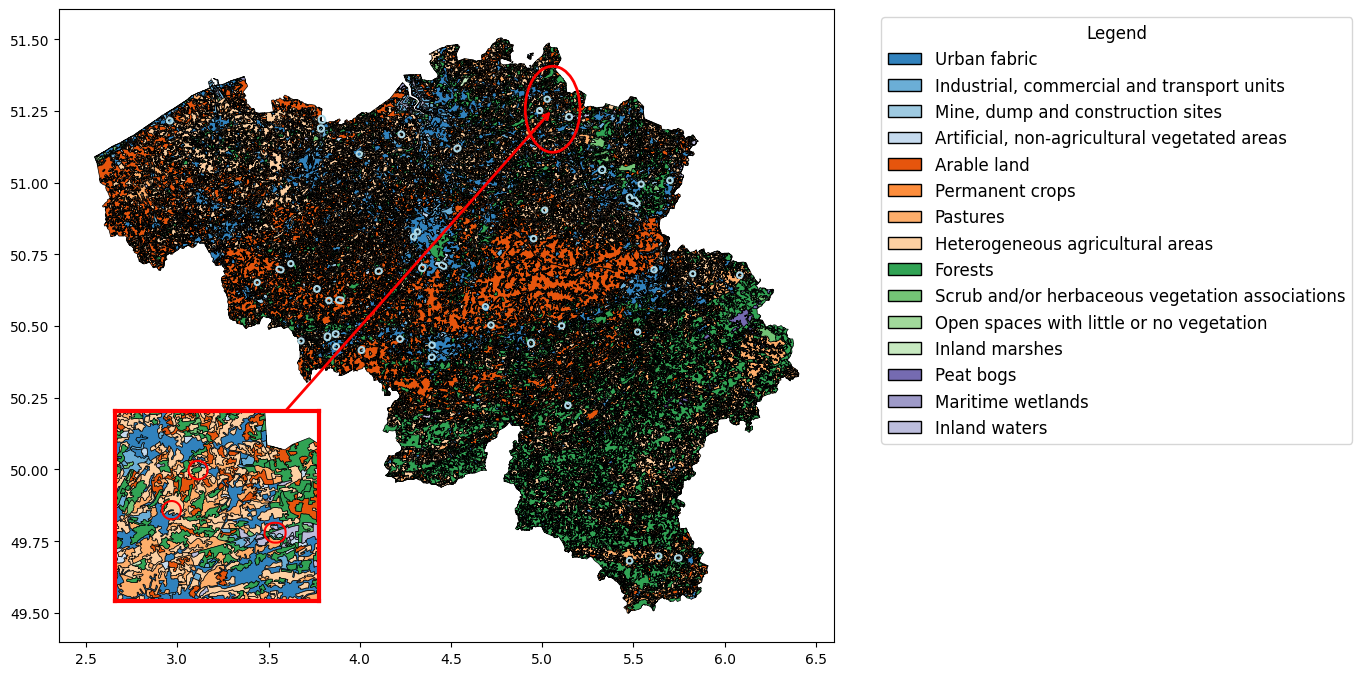

In [58]:
## FOCUS ON POSSIBLE AGRIVOLTAICS OPPORTUNITIES
# look for bbox_min_lon, bbox_min_lat, bbox_max_lon, bbox_max_lat and change their value to zoom in a different area

buffer_for_viz = 1000
solar_gdf_metric_buffered = solar_gdf_metric.copy()
solar_gdf_metric_buffered['geometry'] = solar_gdf_metric_buffered.geometry.buffer(buffer_for_viz)
solar_gdf_buffered = solar_gdf_metric_buffered.to_crs(gdf.crs)

unioned_polygon_solar = unary_union(solar_gdf_buffered.geometry)
perimeter_solar = unioned_polygon_solar.boundary
perimeter_solar_gdf = gpd.GeoDataFrame(geometry=[perimeter_solar], crs=solar_gdf_buffered.crs)

# main plot
# CORINE landuse IE map
lab = 'LABEL2'

# ADD TO LABEL2 THE DISTINCTION OF DIFFERENT INLAND WETLANDS FROM LABEL3
# TO HAVE SAME LABELS OF IRELAND IN FINAL MAP
gdf_peatbogs = gdf.copy()
gdf_peatbogs.loc[gdf_peatbogs['LABEL2'] == 'Inland wetlands', 'LABEL2'] = gdf_peatbogs['LABEL3'] 

# unique labels 
unique_labels = gdf_peatbogs[lab].unique().tolist()
unique_labels.remove('Marine waters') # LABEL3 "Sea and ocean"
num_labels = len(unique_labels)
    
# map label to colors (ensure there are enough unique colors for all unique labels --> max num labels in LABEL3 equal to 35)
colors = plt.cm.tab20c.colors # colors = tuple( [tup for tup in colors if tup[0] <= 0.8] ) # remove red from landtype colors
cmap = ListedColormap(colors[:num_labels])
color_map = {label: cmap(i) for i, label in enumerate(unique_labels)}

# plot
fig, ax = plt.subplots(figsize=(10, 10))
for label, color in color_map.items():
    gdf_peatbogs[gdf_peatbogs[lab] == label].plot(ax=ax, facecolor=color, edgecolor='black', lw=0.5)

# legend 
legend_elements = [Patch(facecolor=color_map[label], edgecolor='black', label=label) for label in unique_labels]
ax.legend(handles=legend_elements, title='Legend', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left')

# plot all buffers around wind farms on top of map
perimeter_solar_gdf.plot(ax=ax, color='lightblue', edgecolor='blue')


## ZOOM IN SECTION

# bbox area around North-East of Flanders - defined using bboxfinder.com
# NOTE: given the high fragmentation of Belgium territory, you may need to zoom-in more and get a smaller bbox
bbox_min_lon, bbox_min_lat, bbox_max_lon, bbox_max_lat = 4.899216, 51.161691, 5.215073, 51.349485 # 4.799652, 51.002522, 5.552216, 51.457430
# center of the bounding box for placing the circle
center_lon = ( (bbox_min_lon + bbox_max_lon) / 2 ) 
center_lat = (bbox_min_lat + bbox_max_lat) / 2

# add circle on map highlighting peatlands area that you want to zoom-in
circle = Circle((center_lon, center_lat), radius=0.15, edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(circle)

# zoomed-in area (to be plotted inside the inserted ax)
inset_ax = inset_axes(ax, width='30%', height='30%', loc='lower left', borderpad=3)
# zoom-in box border
for spine in inset_ax.spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(3)


# CORINE LAND TYPES PLOT ON ZOOM-IN
for label, color in color_map.items():
    gdf_peatbogs[gdf_peatbogs[lab] == label].plot(ax=inset_ax, facecolor=color, edgecolor='black', lw=0.5)
# BUFFERS PERIMETER PLOT ON ZOOM-IN
perimeter_solar_gdf.plot(ax=inset_ax, color='red') 


# arrow
ax.annotate(
    '',  
    xy = (center_lon, center_lat),  # arrow point location (torwards circle on the main map)
    xytext = (0.1, 0.1),  # start of arrow, near zoomed-in area
    textcoords = 'axes fraction',
    arrowprops = dict(color = 'red', arrowstyle = '->', linewidth = 2)
)


# set the extent of the inset map to focus on the bounding box area
inset_ax.set_xlim(bbox_min_lon, bbox_max_lon)
inset_ax.set_ylim(bbox_min_lat, bbox_max_lat)

inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])
inset_ax.set_xticks([])
inset_ax.set_yticks([])

inset_ax.axis('on')

# plt.savefig('img/agrivoltaics_zoom_BE.png', dpi=300, bbox_inches='tight')

plt.show()


In [63]:
landuse_around_solar_df

id                                             LABEL2
0   a1086903048  {Arable land, Heterogeneous agricultural areas...
1   a1371454910  {Arable land, Heterogeneous agricultural areas...
2   a1391041770  {Arable land, Scrub and/or herbaceous vegetati...
3   a1404388448  {Industrial, commercial and transport units, P...
4   a1598072712  {Scrub and/or herbaceous vegetation associatio...
..          ...                                                ...
65    a32472479  {Arable land, Artificial, non-agricultural veg...
66   a530063676  {Heterogeneous agricultural areas, Arable land...
67   a797512166  {Mine, dump and construction sites, Arable lan...
68   a933356026  {Heterogeneous agricultural areas, Inland wate...
69   a957375710  {Scrub and/or herbaceous vegetation associatio...

[70 rows x 2 columns]

In [64]:
print('Number of solar farms without associated landuse in the surrounding {} meters (missing CORINE data): {} over {}'.format(buffer_radius, len(landuse_around_solar_df[landuse_around_solar_df.LABEL2.isna()]), len(landuse_around_solar_df)))

Number of solar farms without associated landuse in the surrounding 1000 meters (missing CORINE data): 0 over 70


In [65]:
all_solar_landuses = landuse_around_solar_df.LABEL2.explode().tolist() 
solar_landuse_around_cnt = Counter(all_solar_landuses)
solar_landuse_around_cnt

Counter({'Urban fabric': 66,
         'Heterogeneous agricultural areas': 64,
         'Forests': 41,
         'Industrial, commercial and transport units': 38,
         'Arable land': 35,
         'Pastures': 33,
         'Scrub and/or herbaceous vegetation associations': 20,
         'Inland waters': 18,
         'Artificial, non-agricultural vegetated areas': 12,
         'Mine, dump and construction sites': 8,
         'Inland wetlands': 3,
         'Permanent crops': 2})

In [67]:
# compute num landuses around each infrastructure (length of each set)
landuse_around_solar_df['num_landuses_around'] = landuse_around_solar_df.LABEL2.apply(lambda x: len(x))

# average number of landtypes within buffer
print('Average num of landtypes around each solar farm: {}'.format(landuse_around_solar_df['num_landuses_around'].mean()))
# std
print('Standard deviation of num of landtypes: {}'.format(landuse_around_solar_df['num_landuses_around'].std()))
# max
print('Maximum num of landtypes around each solar farm: {}'.format(landuse_around_solar_df['num_landuses_around'].max()))
# min
print('Minimum num of landtypes around each solar farm: {}'.format(landuse_around_solar_df['num_landuses_around'].min()))

Average num of landtypes around each solar farm: 4.857142857142857
Standard deviation of num of landtypes: 1.2885866236083794
Maximum num of landtypes around each solar farm: 9
Minimum num of landtypes around each solar farm: 2


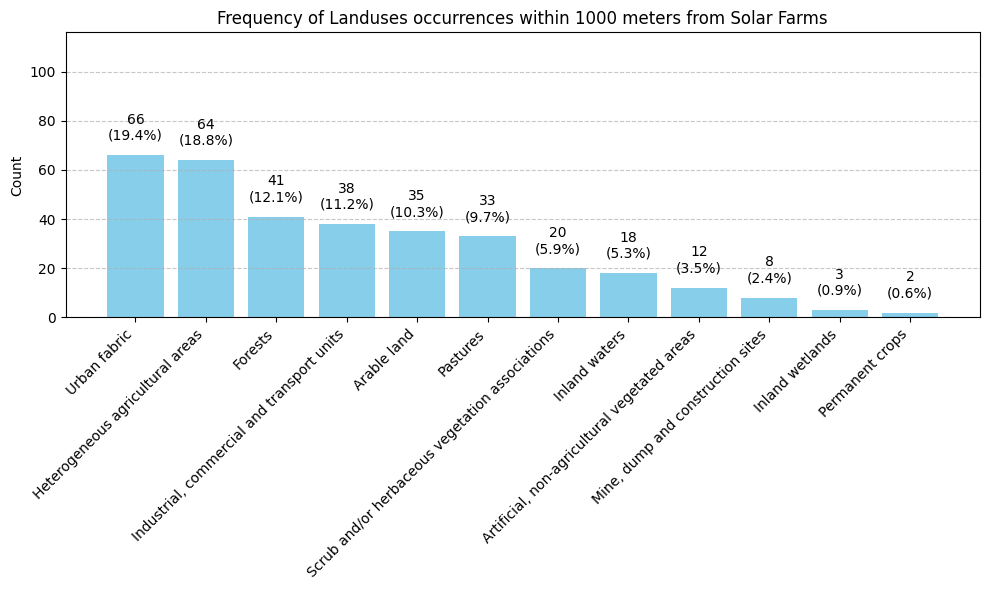

In [69]:
freq_landuse_types(solar_landuse_around_cnt, title_plot=f'Frequency of Landuses occurrences within {buffer_radius} meters from Solar Farms')

In [70]:
# add geometry to landuse_around_solar_df
landuse_around_solar_df = pd.merge(solar_gdf[['id', 'geometry']], landuse_around_solar_df, how='right')
landuse_around_solar_df_mercator = landuse_around_solar_df.to_crs(epsg_latlon)

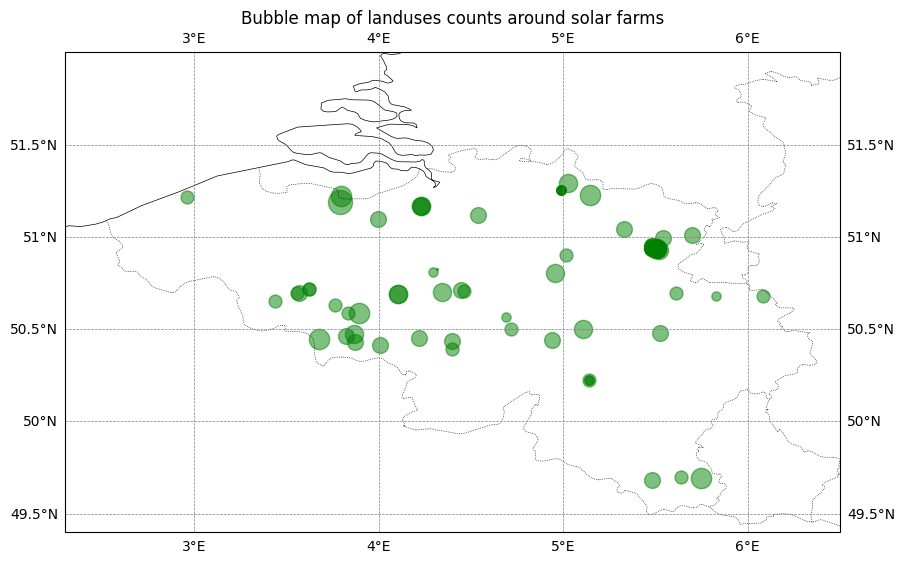

In [71]:
bubble_map(gdf_mercator=landuse_around_solar_df_mercator, zoom_area = [2.3, 6.5, 49.4, 52], bubble_sizes_column = 'num_landuses_around', title='Bubble map of landuses counts around solar farms')

#### Area occupied by landuse - solar farms

In [72]:
landuse_around_solar_df_metric = landuse_around_solar_df_mercator.to_crs(epsg_meter)
share_laduse_around_solar = find_area_covered_by_landuse_within_buffer(landuse_around_infra_gdf1_metric = landuse_around_solar_df_metric[['id', 'geometry']].copy(),
                                                                        landuse_gdf2_metric = landuse_gdf_metric, 
                                                                        unique_id_gdf1 = 'id', 
                                                                        label_column_gdf2 = 'LABEL2', 
                                                                        buffer_radius = buffer_radius)

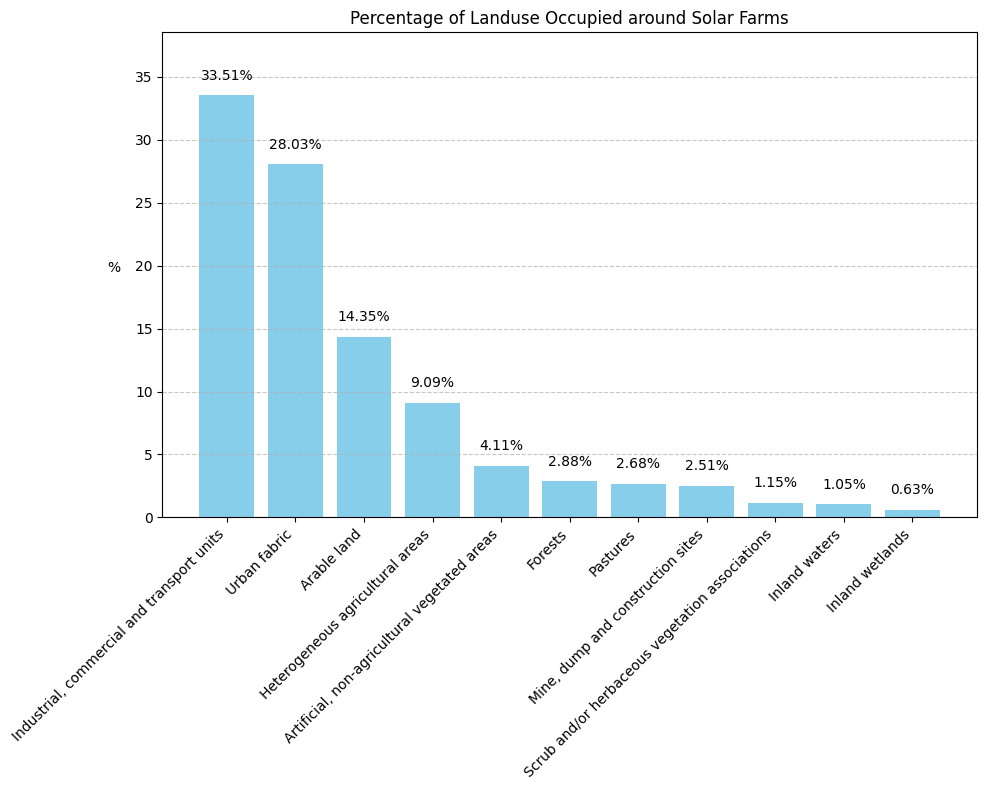

In [73]:
grp_solar_land = share_laduse_around_solar.groupby(['LABEL2']).aggregate({'area_intersection':'sum'}).reset_index()

total_area = grp_solar_land['area_intersection'].sum()
grp_solar_land['perc_landuse'] = (grp_solar_land['area_intersection'] / total_area) * 100

# sort bars
grp_solar_land_sorted = grp_solar_land.sort_values(by='perc_landuse', ascending=False)

### plot barchart
plt.figure(figsize=(10, 8))
bars = plt.bar(grp_solar_land_sorted['LABEL2'], grp_solar_land_sorted['perc_landuse'], color='skyblue')
plt.xlabel('')
plt.ylabel('%       ', rotation=360)  
plt.title('Percentage of Landuse Occupied around Solar Farms')

for bar, percentage in zip(bars, grp_solar_land_sorted['perc_landuse']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim([0, grp_solar_land_sorted['perc_landuse'].max() + 5])
plt.tight_layout()
plt.show()

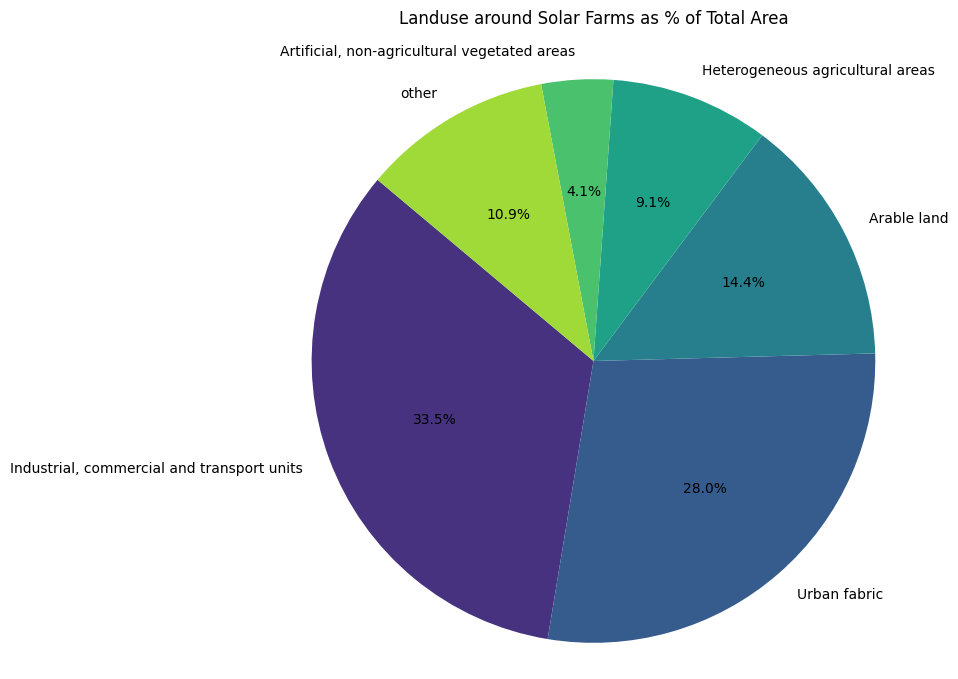

In [74]:
# viz_threshold = 4. # %
grp_solar_land_above_threshold = grp_solar_land_sorted[grp_solar_land_sorted.perc_landuse > viz_threshold].reset_index(drop=True)
others_row_solar = pd.DataFrame([['other', grp_solar_land_sorted[grp_solar_land_sorted.perc_landuse < viz_threshold].area_intersection.sum(), grp_solar_land_sorted[grp_solar_land_sorted.perc_landuse < viz_threshold].perc_landuse.sum()]], columns=grp_solar_land_above_threshold.columns)
reduced_solar_landuse = pd.concat([grp_solar_land_above_threshold, others_row_solar], ignore_index=True)

### plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(reduced_solar_landuse.perc_landuse, labels=reduced_solar_landuse['LABEL2'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis')) 
plt.title('Landuse around Solar Farms as % of Total Area\n')
plt.axis('equal')  
plt.show()